# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [1]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/sc/NoisyReach.jl`


## 2. Validation for Integral function

In [2]:
#const Ts = 0.01
#const Dc = 0.005 # 
#sys = benchmarks[:F1]

In [3]:
#sys_aug_ = let
#    ϕ = ℯ^(Ts * sys.A)
#    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
#    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
#    ϕ_aug = [ϕ Γ₁; 0 0 0]
#    Γ_aug = [Γ₀; I]
#    C_aug = [sys.C 0]
#    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
#end

In [4]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
#sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

## 3. Physical System and Neural Networks Uncertainty Setup

In [5]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 = period
const Dc2 = 0.015

0.015

In [6]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, Dc2, period)
    Γ1 = matrix_integral(sys.A, sys.B, Dc1, Dc2)
    Γ3 = matrix_integral(sys.A, sys.B, 0.0, Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, period)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 -0.33729  -0.426093  -0.159122
  0.51363   0.766571   0.288655

In [7]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0]

3-element Vector{Float64}:
 1.0
 1.0
 0.0

## 4. Calculate and Plot Reachable Trajectories

In [8]:
all_trajectories=[]
number = 2
for i in 1:10000
    z = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories, z)
end
z_ideal = ideal_evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0)

11-element Vector{Vector{Float64}}:
 [1.0, 1.0, 0.0]
 [1.13, 1.0, 0.0]
 [1.2841181614967208, 1.2120277933777672, 1.3469721877629315]
 [1.5113218430169284, 2.051521322291608, 1.9774769954194076]
 [1.8803297205383305, 3.2846083580634104, 2.9197053591514854]
 [2.45845542823024, 5.105832737966661, 4.3264665254863415]
 [3.346218849704, 7.805108894700128, 6.425575605051187]
 [4.693629582729828, 11.814533885967295, 9.556662580704183]
 [6.724462668751569, 17.77817237401142, 14.226045830087523]
 [9.772448809577966, 26.65608883682096, 21.18853552379878]
 [14.335226174521587, 39.879434271877486, 31.56938303802392]

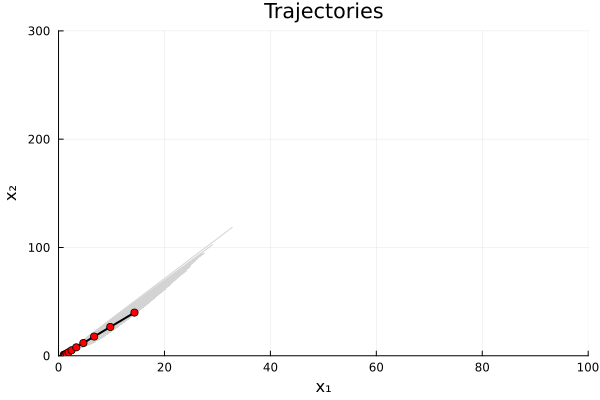

In [9]:
traj_plot = plot(title="Trajectories", xlabel="x₁", ylabel="x₂")
for trajectory in all_trajectories
    x = [point[1] for point in trajectory]
    y = [point[2] for point in trajectory]
    
    plot!(x, y, xlim=(0,100), ylim=(0, 300), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
end
x_z = [point[1] for point in z_ideal]
y_z = [point[2] for point in z_ideal]
plot!(x_z, y_z, xlim=(0,100), ylim=(0, 300), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=4)
display(traj_plot)